# IW Equivalence Rig

## Introduction

During the welding of RR1000 components, the torque peaks to values close to 300kNm. Calibrate the rig for this value of torque could be very difficult (not something that could be done at UoN), therefore Chris Bennett proposed the idea to modify the process and find a combination of material that do not weld under realistic loads in order to have a rig that measures effectively the efficiency of the system (and all the other required parameters) which is subjected to a low torque (so simple to validate).

## Plastic - Feasibility analysis

Currently in LFW Andrew Walpole and his colleagues use plastic to run the LFW process under realistic loads but avoiding welding. Similarly, the first idea was to try steel vs plastic in order to see if, given the low friction coefficient of some plastic, could be possible to have temperature low enough to avoid the melting of the plastic.

### Input parameters

In [1]:
import math
import pint
import numpy as np
ureg = pint.UnitRegistry()
inertia = 85123 * ureg.kilogram * ureg.meter ** 2
angularSpeed = 60.6 * ureg.rpm
thrust = 3774000 * ureg.newton
d_min = 310 * ureg.millimeter
d_max = 440 * ureg.millimeter
section = math.pi * (d_max ** 2 - d_min **2) / 4
pressure = thrust / section
print("Pressure: ", pressure.to("megapascal"))
print("Pressure: ", pressure.to("psi"))
print("Inertia: ", inertia)
print("Angular Speed: ", angularSpeed)
print("Angular Speed: ", angularSpeed.to("rad / sec"))
print("Section: ", section)

Pressure:  49.28416453159492 megapascal
Pressure:  7148.063729585943 pound_force_per_square_inch
Inertia:  85123.0 kilogram * meter ** 2
Angular Speed:  60.6 revolutions_per_minute
Angular Speed:  6.346017160251382 radian / second
Section:  76576.3209312512 millimeter ** 2


Parameters useful to analyse wear-resistant plastics:

In [2]:
meanDiam = (d_max + d_min) / 2
slidingVelocity = (meanDiam / 2) * angularSpeed # v = angVel * r
print("Sliding velocity", slidingVelocity.to("meter / sec"))
PV = pressure * slidingVelocity
print("PV: ", PV.to("megapascal * meter / sec"))
print("PV: ", PV.to("psi * ft / min"))

Sliding velocity 1.1898782175471343 meter / second
PV:  58.64215384615387 megapascal * meter / second
PV:  1674276.639660048 foot * pound_force_per_square_inch / minute


Considering a constant friction coefficient it is possible to estimate the torque:

In [3]:
frictionCoeff = 0.1
print("Friction coefficient: ", frictionCoeff)
torque = 2.0 / 3.0 * math.pi * pressure * frictionCoeff * ((d_max / 2) ** 3 - (d_min / 2) ** 3)
print("Torque: ", torque.to("kilonewton * meter"))

Friction coefficient:  0.1
Torque:  71.47117333333335 kilonewton * meter


The principal stresses on the workpiece could be calculated as:

s_x:  -49.28416453159492 megapascal
t_xy:  5.6702288516344375 megapascal
s_1:  0.6439556528689856 megapascal
s_2:  -49.92812018446391 megapascal


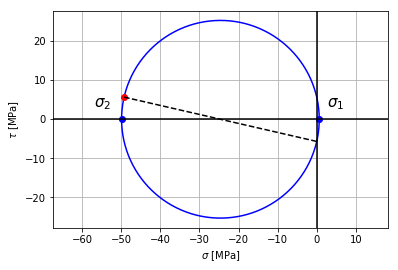

In [4]:
import matplotlib.pyplot as plt
s_x = -pressure # Negative because it is compression
J_p = 0.5 * math.pi * ((d_max / 2) ** 4 - (d_min / 2) ** 4)
t_xy = torque * (d_max / 2) / J_p
print("s_x: ", s_x.to("megapascal"))
print("t_xy: ", t_xy.to("megapascal"))
s_1 = s_x / 2 + ((s_x / 2) ** 2 + t_xy ** 2) ** 0.5
s_2 = s_x / 2 - ((s_x / 2) ** 2 + t_xy ** 2) ** 0.5
print("s_1: ", s_1.to("megapascal"))
print("s_2: ", s_2.to("megapascal"))
x_Mohr = (max(s_1.magnitude, s_2.magnitude) + min(s_1.magnitude, s_2.magnitude)) / 2 + \
(max(s_1.magnitude, s_2.magnitude) - min(s_1.magnitude, s_2.magnitude)) / 2 * np.cos(np.linspace(0, 2 * math.pi, 360))
y_Mohr = (max(s_1.magnitude, s_2.magnitude) - min(s_1.magnitude, s_2.magnitude)) / 2 * np.sin(np.linspace(0, 2 * math.pi, 360)) 
fig, ax = plt.subplots()
plt.plot(x_Mohr, y_Mohr, 'b')
plt.plot(s_1.magnitude, 0, "ob")
plt.plot(s_2.magnitude, 0, "ob")
plt.plot(s_x.magnitude, t_xy.magnitude, "or")
plt.plot([s_x.magnitude, 0], [t_xy.magnitude, -t_xy.magnitude], "--k")
ax.set_aspect('equal', 'datalim')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_xlabel("$\sigma$ [MPa]")
# Occhio al maledetto escape
ax.set_ylabel("$\\tau$ [MPa]")
ax.text(s_1.magnitude + 2, 3, '$\sigma_{1}$', fontsize=15)
ax.text(s_2.magnitude - 7, 3, '$\sigma_{2}$', fontsize=15)
plt.grid()
plt.show()

Considering the Coulomb-Mohr failure criteria:

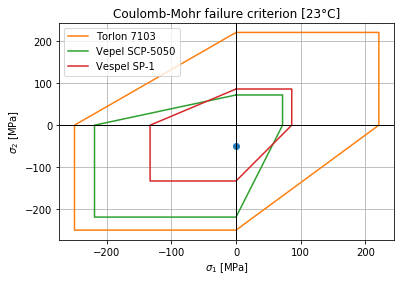

In [17]:
###
## Solvay
#
# Stress condition
plt.plot(s_1.magnitude, s_2.magnitude, "o")
# Tensile and compressive strength for different materials
strength = []
strength.append([221 * ureg("megapascal"), 250 * ureg("megapascal"), "Torlon 7103"])
strength.append([72 * ureg("megapascal"), 219 * ureg("megapascal"), "Vepel SCP-5050"])
strength.append([86.2 * ureg("megapascal"), 133 * ureg("megapascal"), "Vespel SP-1"])
for s in strength:
    plt.plot([0, s[0].magnitude, s[0].magnitude, 0, -s[1].magnitude, -s[1].magnitude, 0],
             [s[0].magnitude, s[0].magnitude, 0, -s[1].magnitude, -s[1].magnitude, 0, s[0].magnitude],
            label=s[2])
plt.legend()
plt.grid()
plt.axes().set_xlabel("$\sigma_{1}$ [MPa]")
plt.axes().set_ylabel("$\sigma_{2}$ [MPa]")
plt.axes().axvline(x=0, linewidth=1, color='k')
plt.axes().axhline(y=0, linewidth=1, color='k')
plt.title("Coulomb-Mohr failure criterion @ 23°C")
plt.show()

Temperature dependent analysis:

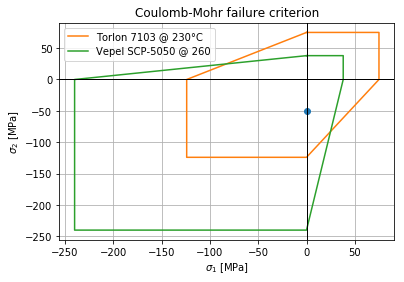

In [18]:
# Stress condition
plt.plot(s_1.magnitude, s_2.magnitude, "o")
# Tensile and compressive strength for different materials
strength = []
strength.append([75 * ureg("megapascal"), 124 * ureg("megapascal"), "Torlon 7103 @ 230°C"])
strength.append([38 * ureg("megapascal"), 240 * ureg("megapascal"), "Vepel SCP-5050 @ 260"])
for s in strength:
    plt.plot([0, s[0].magnitude, s[0].magnitude, 0, -s[1].magnitude, -s[1].magnitude, 0],
             [s[0].magnitude, s[0].magnitude, 0, -s[1].magnitude, -s[1].magnitude, 0, s[0].magnitude],
            label=s[2])
plt.legend()
plt.grid()
plt.axes().set_xlabel("$\sigma_{1}$ [MPa]")
plt.axes().set_ylabel("$\sigma_{2}$ [MPa]")
plt.axes().axvline(x=0, linewidth=1, color='k')
plt.axes().axhline(y=0, linewidth=1, color='k')
plt.title("Coulomb-Mohr failure criterion")
plt.show()

### Abaqus simulation

Total time: 7.558180361929767 second
(Total) Initial Heat Flux: 5922944.415726498 watt / meter ** 2
Initial Heat Flux for similar welds: 2961472.207863249 watt / meter ** 2


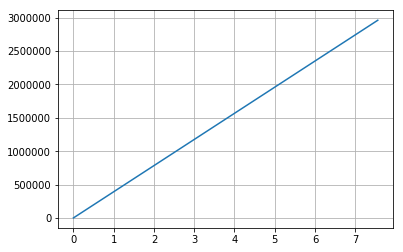

In [10]:
angularAcc = torque / inertia
totalTime = angularSpeed / angularAcc
print("Total time:", totalTime.to("sec"))
initialHeatFlux = torque * angularSpeed / section
print("(Total) Initial Heat Flux:", initialHeatFlux.to("watt / m ** 2"))
initialHeatFlux_OneWorkpiece = 0.5 * initialHeatFlux
print("Initial Heat Flux for similar welds:", initialHeatFlux_OneWorkpiece.to("watt / m ** 2"))
time = np.linspace(0, totalTime.to("sec").magnitude)
flux = np.linspace(0, initialHeatFlux_OneWorkpiece.to("watt / m ** 2").magnitude)
plt.plot(time, flux)
plt.grid()
plt.show()

In [11]:
# Parameters for the plastic
thermalConductivity_P = 0.37
specificHeat_P = 1.81 * 10**3
specificGravity_P = 1.41
# Parameters for the metal (AISI 1020)
thermalConductivity_M = 51.9
specificHeat_M = 519 # Considero il valore 200 degC (che e' quello fornito per Solvay KT-880 CF30)
specificGravity_M = 7.87
# The ratio of heat in eavh material is calculated considering the formula proposed by Balasubramanian, 1999
k_P = math.sqrt(thermalConductivity_P * specificHeat_P * specificGravity_P) / \
    (math.sqrt(thermalConductivity_P * specificHeat_P * specificGravity_P) + \
    math.sqrt(thermalConductivity_M * specificHeat_M * specificGravity_M))
k_M = math.sqrt(thermalConductivity_M * specificHeat_M * specificGravity_M) / \
    (math.sqrt(thermalConductivity_P * specificHeat_P * specificGravity_P) + \
    math.sqrt(thermalConductivity_M * specificHeat_M * specificGravity_M))
print("Percentage of heat plastic: ", k_P)
print("Percentage of heat metal: ", k_M)
print("Heat in the plastic: ", initialHeatFlux.to("watt / m ** 2") * k_P)
print("Heat in the metal: ", initialHeatFlux.to("watt / m ** 2") * k_M)

Percentage of heat plastic:  0.06256563434231308
Percentage of heat metal:  0.9374343656576869
Heat in the plastic:  370572.7745441892 watt / meter ** 2
Heat in the metal:  5552371.641182308 watt / meter ** 2


#### FEM results analysis

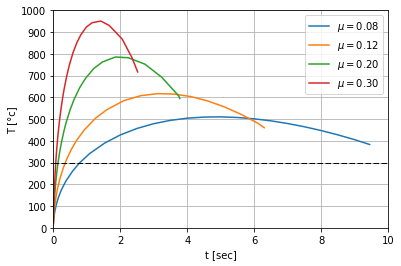

In [12]:
x_008 = [0, 0.01, 0.02, 0.029999999, 0.050000001, 0.090000004, 0.150000006, 0.239999995, 0.375, 0.577499986, 0.779999971, 1.08375001, 1.539374948, 1.995000005, 2.494999886, 2.994999886, 3.494999886, 3.994999886, 4.494999886, 4.994999886, 5.494999886, 5.994999886, 6.494999886, 6.994999886, 7.494999886, 7.994999886, 8.494999886, 8.994999886, 9.447730064]
y_008 = [20, 36.06214142, 49.57006836, 61.19093704, 79.78408051, 107.5375443, 138.7490082, 174.2970734, 214.9089355, 261.0925293, 297.8938904, 341.2685242, 390.1051941, 426.612915, 456.72052, 478.6913757, 494.0874939, 504.0028381, 509.1751099, 510.1621399, 507.3970337, 501.2235718, 491.9233398, 479.7309265, 464.84375, 447.4290771, 427.6230774, 405.5272522, 383.1524353]
x_012 = [0, 0.01, 0.02, 0.029999999, 0.050000001, 0.079999998, 0.125, 0.192499995, 0.293749988, 0.395000011, 0.546875, 0.698750019, 0.926562488, 1.268281221, 1.610000014, 2.109999895, 2.609999895, 3.109999895, 3.609999895, 4.110000134, 4.610000134, 5.110000134, 5.610000134, 6.110000134, 6.298480034]
y_012 = [20, 44.08683395, 64.33059692, 81.73377228, 109.4601212, 141.8463135, 179.5710297, 223.2673645, 273.6108093, 314.3583374, 363.0683899, 402.785614, 450.6555786, 504.8400574, 544.4407349, 584.8736572, 607.586792, 616.8492432, 614.9567261, 603.4727783, 583.5341187, 556.0081177, 521.5765381, 480.7879028, 460.3942871]
x_020 = [0, 0.01, 0.02, 0.029999999, 0.045000002, 0.067500003, 0.10125, 0.135000005, 0.185625002, 0.236249998, 0.312187493, 0.388125002, 0.502031267, 0.615937471, 0.786796868, 0.957656264, 1.21394527, 1.470234394, 1.854668021, 2.239101648, 2.739101648, 3.239101648, 3.739101648, 3.779089928]
y_020 = [20, 60.12345886, 93.80262756, 122.4693985, 157.9113922, 200.7483368, 251.4886627, 293.5411072, 344.9328918, 388.1277771, 441.9614258, 487.3106384, 543.0584717, 588.9552612, 644.1011353, 686.5368652, 733.4905396, 762.8746948, 785.475769, 782.0748901, 752.3416748, 692.211792, 607.7333374, 594.4662476]
x_030 = [0, 0.01, 0.02, 0.029999999, 0.045000002, 0.059999999, 0.082500003, 0.104999997, 0.138750002, 0.172499999, 0.223124996, 0.273750007, 0.324375004, 0.400312513, 0.476249993, 0.590156257, 0.704062521, 0.817968726, 0.988828123, 1.159687519, 1.415976524, 1.672265649, 2.056699276, 2.351421833, 2.519390106]
y_030 = [20, 80.14531708, 129.9853516, 172.1104279, 223.9009399, 267.7327271, 322.0292969, 368.2898865, 426.5190125, 476.7794189, 540.019104, 593.5016479, 639.6784058, 698.2435913, 747.0010986, 806.215271, 851.7438965, 886.3911743, 923.6296997, 943.1392822, 950.9058228, 930.3110962, 867.9787598, 781.6887817, 716.7546997]
plt.plot(x_008, y_008, label="$\mu=0.08$")
plt.plot(x_012, y_012, label="$\mu=0.12$")
plt.plot(x_020, y_020, label="$\mu=0.20$")
plt.plot(x_030, y_030, label="$\mu=0.30$")
plt.axes().axhline(y=300, linewidth=1, color='k', linestyle='--')
plt.axes().set_xlabel("t [sec]")
plt.axes().set_ylabel("T [°c]")
plt.yticks(np.linspace(0, 1000, 11))
plt.axes().set_xlim([0,10])
plt.axes().set_ylim([0,1000])
plt.legend()
plt.grid()
plt.show()

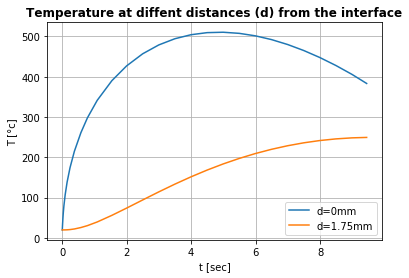

In [13]:
x_008_2 = [0, 0.01, 0.02, 0.029999999, 0.050000001, 0.090000004, 0.150000006, 0.239999995, 0.375, 0.577499986, 0.779999971, 1.08375001, 1.539374948, 1.995000005, 2.494999886, 2.994999886, 3.494999886, 3.994999886, 4.494999886, 4.994999886, 5.494999886, 5.994999886, 6.494999886, 6.994999886, 7.494999886, 7.994999886, 8.494999886, 8.994999886, 9.447730064]
y_008_2 = [20, 20.00048828, 20.00186539, 20.00446701, 20.01657295, 20.07881737, 20.27821541, 20.84858322, 22.33839417, 25.9029274, 30.62756348, 39.71445465, 56.14056778, 74.0484848, 94.28661346, 114.2928696, 133.5233612, 151.6255646, 168.3760986, 183.6382141, 197.3331146, 209.4205322, 219.8859253, 228.73172, 235.9715118, 241.6260834, 245.7203217, 248.2807617, 249.3447876]
plt.plot(x_008, y_008, label="d=0mm")
plt.plot(x_008_2, y_008_2, label="d=1.75mm")
plt.axes().set_xlabel("t [sec]")
plt.axes().set_ylabel("T [°c]")
plt.title("Temperature at diffent distances (d) from the interface", fontweight='bold')
plt.legend()
plt.grid()
plt.show()

If a coating is used, it is possible to use metal vs metal:

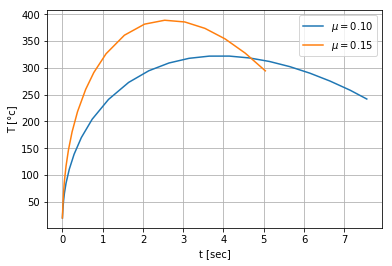

In [14]:
x_010 = [0, 0.01, 0.02, 0.029999999, 0.050000001, 0.090000004, 0.170000002, 0.289999992, 0.469999999, 0.74000001, 1.144999981, 1.644999981, 2.144999981, 2.644999981, 3.144999981, 3.644999981, 4.144999981, 4.644999981, 5.144999981, 5.644999981, 6.144999981, 6.644999981, 7.144999981, 7.558179855]
y_010 = [20, 33.57107544, 44.2751503, 53.01498413, 66.16419983, 84.8360672, 110.6928482, 138.7769623, 169.8726349, 204.1934052, 241.0456543, 272.7763062, 294.4728699, 308.9482117, 317.6982117, 321.7731628, 321.8369751, 318.3703918, 311.73349, 302.2027893, 289.9945068, 275.2799072, 258.1953125, 241.7885437]
x_015 = [0, 0.01, 0.02, 0.029999999, 0.050000001, 0.090000004, 0.150000006, 0.239999995, 0.375, 0.577499986, 0.779999971, 1.08375001, 1.539374948, 2.039375067, 2.539375067, 3.039375067, 3.539375067, 4.039374828, 4.539374828, 5.038790226]
y_015 = [20, 40.3498764, 56.38719177, 69.46846008, 89.11821747, 116.7666092, 146.8803253, 180.495575, 218.1576385, 259.7459106, 291.2343445, 326.2072449, 360.7950745, 381.4345703, 388.710022, 385.5024719, 373.5525818, 353.9249268, 327.3431091, 294.3399658]
plt.plot(x_010, y_010, label="$\mu=0.10$")
plt.plot(x_015, y_015, label="$\mu=0.15$")
plt.axes().set_xlabel("t [sec]")
plt.axes().set_ylabel("T [°c]")
plt.legend()
plt.grid()
plt.show()

Analysis of the stress in on of the metal components:

Equivalent tensile stress:  50.25319252810752 newton / millimeter ** 2
Security factor:  6.96473163977072 megapascal * millimeter ** 2 / newton


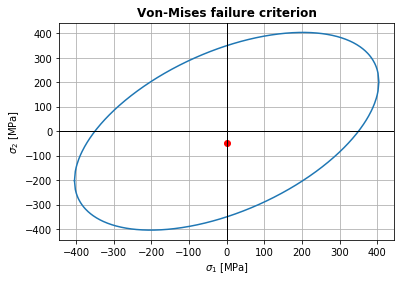

In [15]:
aisi_1020_yieldStress = 350 * ureg("megapascal")
s_eq = (s_1 ** 2 + s_2 ** 2 - s_1 * s_2) ** 0.5
SF = aisi_1020_yieldStress / s_eq
print("Equivalent tensile stress: ", s_eq)
print("Security factor: ", SF)
# Il round e' necessario per evitare l'errore di arrotondamento di math.sqrt(3) che farebbe andare
# in errore la radice dentro y1 e y2
x_VM = np.linspace(- 2 * aisi_1020_yieldStress.magnitude / round(math.sqrt(3), 9),
                   2 * aisi_1020_yieldStress.magnitude  / round(math.sqrt(3), 9), 360)
# y1 e y2 sono le due metà del diagramma di Von Mises (metà positiva e negativa)
y1 = lambda x: ((x + math.sqrt(x ** 2 - 4 * (x **2 - aisi_1020_yieldStress.magnitude ** 2))) / 2)
y2 = lambda x: ((x - math.sqrt(x ** 2 - 4 * (x **2 - aisi_1020_yieldStress.magnitude ** 2))) / 2)
plt.plot(x_VM.tolist() + x_VM.tolist()[::-1] , [y1(xx) for xx in x_VM] + [y2(xx) for xx in x_VM][::-1])
plt.plot(s_1.magnitude, s_2.magnitude, 'or')
plt.grid()
plt.axes().axvline(x=0, linewidth=1, color='k')
plt.axes().axhline(y=0, linewidth=1, color='k')
plt.axes().set_xlabel("$\sigma_{1}$ [MPa]")
plt.axes().set_ylabel("$\sigma_{2}$ [MPa]")
plt.title("Von-Mises failure criterion", fontweight='bold')
plt.show()

### Graphite

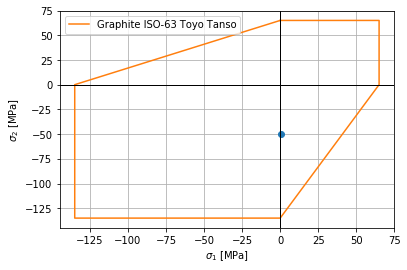

In [16]:
strength=[65 * ureg("megapascal"), 135 * ureg("megapascal"), "Graphite ISO-63 Toyo Tanso"]
plt.plot(s_1.magnitude, s_2.magnitude, "o")
plt.plot([0, strength[0].magnitude, strength[0].magnitude, 0, -strength[1].magnitude, -strength[1].magnitude, 0],
             [strength[0].magnitude, strength[0].magnitude, 0, -strength[1].magnitude, -strength[1].magnitude, 0,
              strength[0].magnitude], label=strength[2])
plt.axes().axvline(x=0, linewidth=1, color='k')
plt.axes().axhline(y=0, linewidth=1, color='k')
plt.axes().set_xlabel("$\sigma_{1}$ [MPa]")
plt.axes().set_ylabel("$\sigma_{2}$ [MPa]")
plt.grid()
plt.legend()
plt.show()